In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [2]:
import torch
import os
import pickle
import pandas as pd
import numpy as np
from modules.functions import pymatgen_comp, data_generator_vec, check_cuda
from sklearn.neighbors import KernelDensity
from modules.trained_models import get_uts_without_grain
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
import umap

2022-11-04 02:02:13.249937: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [82]:
model_path = 'saved_models'
if os.path.exists(os.path.join(model_path, 'GAN_generator_6_dims.pt')):
    generator = torch.jit.load(os.path.join(model_path, 'GAN_generator_6_dims.pt'), map_location='cpu')
else:
    print('train model first!')

el_list_loc = 'misc/element_order_uts.pkl'
with open(el_list_loc,'rb') as fid:
    el_list = pickle.load(fid)

with open('misc/scaler_y.pkl','rb') as fid:
    uts_scaler = pickle.load(fid)

In [83]:
dataset = pd.read_csv('dataset/synthetic_dataset.csv', index_col = 0)
to_train_df = dataset[dataset['uts1200C']>0].copy()
comp_dset = data_generator_vec(to_train_df['Composition'], el_list=el_list)
vec_comps = comp_dset.real_data
y = to_train_df['uts1200C'].values.reshape(-1,1).astype('float32')
y_scaled = uts_scaler.transform(y)
kde = KernelDensity(kernel='gaussian',bandwidth=0.5)
v = kde.fit(y_scaled)

def prop_sampler(n_samples):
    return kde.sample(n_samples).astype('float32')

def noise_sampler(N, z_dim):
    return np.random.normal(size=[N, z_dim]).astype('float32')

latent_dim = 6
cuda = check_cuda()

## directions of W and other element variance

In [84]:
n_samples  =100000
uniform_noise = np.random.uniform(0,1, size = (n_samples, latent_dim)).astype('float32')
gen_input = torch.from_numpy(uniform_noise)
prop_input = prop_sampler(n_samples)
prop_input =  torch.from_numpy(prop_input)
if cuda:
        generator = generator.cuda()
        gen_input = gen_input.cuda()
        prop_input = prop_input.cuda()
g_fake_data = generator(gen_input,prop_input).to('cpu').detach().numpy()
uts_synthetic = [get_uts_without_grain(i.reshape(1,-1)).item() for i in g_fake_data]
w_ind = np.argwhere(el_list == 'W').item()
w_content = g_fake_data[:,w_ind]
el_list_to_consider = ['Nb','Mo','Zr','Ti','V','Hf','Cr','Ta','W']
corr_mat = np.zeros((len(el_list_to_consider),latent_dim))
for j,el in enumerate(el_list_to_consider):
        el_ind = np.argwhere(el_list == el).item()
        el_content = g_fake_data[:,el_ind]
        for i in range(uniform_noise.shape[1]):
                corr_mat[j,i] = pearsonr(uniform_noise[:,i], el_content)[0]

[Text(0, 0.5, 'Nb'),
 Text(0, 1.5, 'Mo'),
 Text(0, 2.5, 'Zr'),
 Text(0, 3.5, 'Ti'),
 Text(0, 4.5, 'V'),
 Text(0, 5.5, 'Hf'),
 Text(0, 6.5, 'Cr'),
 Text(0, 7.5, 'Ta'),
 Text(0, 8.5, 'W')]

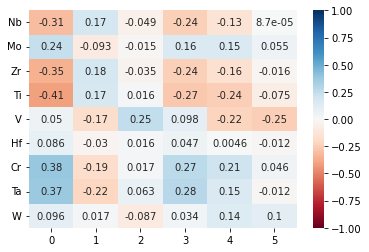

In [85]:
fig,ax = plt.subplots()
ax = sns.heatmap(corr_mat, vmax = 1, vmin = -1, annot = True, cmap = 'RdBu')
ax.set_yticklabels(el_list_to_consider, rotation=360)

In [86]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
hf_ind = np.argwhere(el_list == 'Hf').item()
hf_content = g_fake_data[:,hf_ind]
kf = KFold(n_splits=10)
kf.get_n_splits(uniform_noise)
predicted_w, predicted_hf = [],[]
for i, (train_idx,test_idx) in enumerate(kf.split(uniform_noise)):
    X_train, y_train_w, y_train_hf = uniform_noise[train_idx], w_content[train_idx], hf_content[train_idx]
    X_test, y_test_w, y_test_hf = uniform_noise[test_idx],w_content[test_idx],hf_content[test_idx]
    LNRmodel_w, LNRmodel_hf = LinearRegression(), LinearRegression()
    LNRmodel_w.fit(X_train,y_train_w)
    LNRmodel_hf.fit(X_train,y_train_hf)
    y_pred_w = LNRmodel_w.predict(X_test)
    y_pred_hf = LNRmodel_hf.predict(X_test)
    predicted_w.append(pearsonr(y_pred_w,y_test_w)[0])
    predicted_hf.append(pearsonr(y_pred_hf,y_test_hf)[0])
print(f'Mean of W linear model : {np.mean(predicted_w)}, Std of W linear model : {np.std(predicted_w)}')
print(f'Mean of Hf linear model : {np.mean(predicted_hf)}, Std of Hf linear model : {np.std(predicted_hf)}')

Mean of W linear model : 0.21919228565450366, Std of W linear model : 0.008444895358946596
Mean of Hf linear model : 0.1039720035936, Std of Hf linear model : 0.014058067213022513


## Local manifold fitting

In [87]:
from matplotlib.patches import Circle
test = uniform_noise
circ = Circle(test[100], radius = 0.15)
count = 0
points, inds = [],[]
for i in range(len(test)):
        if circ.contains_point(test[i]):
                points.append(test[i])
                inds.append(i)
points = np.array(points).reshape(-1,latent_dim)
print(len(points))
reducer = umap.UMAP()
try:
        embedding = reducer.fit_transform(points)
except:
        pass


#print(circ.contains_point([2,2]))

7099


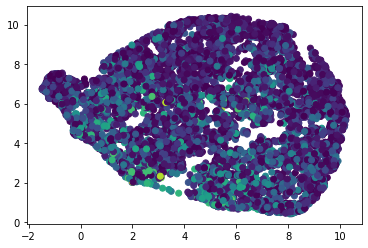

In [88]:
plt.scatter(embedding[:,0],embedding[:,1], c = hf_content[inds])

In [89]:
kf = KFold(n_splits=10)
kf.get_n_splits(embedding)
y = w_content[inds]
predicted_w, predicted_hf = [],[]
for i, (train_idx,test_idx) in enumerate(kf.split(embedding)):
    X_train, y_train_hf = embedding[train_idx], y[train_idx]
    X_test, y_test_hf = embedding[test_idx],y[test_idx]
    LNRmodel_hf = LinearRegression()
    LNRmodel_hf.fit(X_train,y_train_hf)
    y_pred_hf = LNRmodel_hf.predict(X_test)
    predicted_hf.append(pearsonr(y_pred_hf,y_test_hf)[0])
print(f'Mean of Hf linear model : {np.mean(predicted_hf)}, Std of Hf linear model : {np.std(predicted_hf)}')

Mean of Hf linear model : 0.13376736074390147, Std of Hf linear model : 0.023603426858437818
